#### Barbara Karakyriakou
#### MCB112
#### The Moriarty Brain Atlas

Moriarty is gearing up to do a comprehensive single-cell RNA-seq experiment on the dissociated cells of an entire human brain, which is about 200 billion cells.
At the going rate of about $1/cell, Moriarty plans to write an NIH grant for about $200 billion.
Since the NIH budget is only $37B/year, his plan for the Moriarty Brain Atlas includes forcing everyone else into retirement.
He's been going around the lab making unsubtle comments about using your brain for his project, since you won't be needing it any more.
#### Moriarty's preliminary control data
For his preliminary results section, to demonstrate feasibility, he has collected two single cell RNA-seq data sets of known neural cell types as positive controls, and he's trying to show that he can do cluster analysis to discover cell types.
[Dataset 1 (the small set)](http://mcb112.org/w11/w11-data-small.tbl) consists of mapped read count data for 38 cells and 24 genes.
The last column in the data table identifies the known cell type labels 0-7 for 8 different neural cell types.
[Dataset 2 (the large set)](http://mcb112.org/w11/w11-data-large.tbl) has mapped read counts for 1854 cells and 32 genes, and the last column assigns labels 0-15 for 16 different neural cell types.
Moriarty has been trying to use PCA to visualize clusters in his positive control data:
#### 1. verify that PCA fails
Download dataset 1 and dataset 2 (included in this repository). Use PCA to project the data into two dimensions.

Plot your PCA projections for the two data sets, with points colored according to their known cell types. You should get a figure essentially identical to Moriarty's above.

In [27]:
import pandas as pd
import numpy as np
import math
import scipy.stats 
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances
import scipy.spatial.distance as distance
import scipy.optimize as optimize

In [2]:
small_df = pd.read_table('w13-data-small.tbl', delim_whitespace = True)
small_df.shape

(37, 25)

In [3]:
small_df.head()

,nectarine,cauliflower,pineapple,tangerine,watermelon,papaya,endive,ginger,lettuce,broccoli,...,lime,guava,parsley,chickpea,horseradish,wasabi,artichoke,pumpkin,zucchini,type
0,91,47,48,272,84,110,434,0,68,42,...,2,316,194,97,10,80,0,0,42,6
1,235,1,309,36,98,70,2,1,239,69,...,3,356,77,113,223,126,1,2,108,4
2,0,1,43,0,104,37,2,5,155,78,...,1,0,40,19,231,49,2,0,131,0
3,2,78,19,1,231,78,15,2,115,97,...,0,0,166,42,34,61,0,3,11,2
4,2,334,235,0,21,79,150,84,104,88,...,530,0,109,152,84,244,103,235,21,3


In [4]:
large_df = pd.read_table('w13-data-large.tbl', delim_whitespace = True)
large_df.shape

(1679, 33)

In [5]:
large_df.head()

,currant,watercress,cantaloupe,cauliflower,onion,ginger,horseradish,endive,lavender,guava,...,pumpkin,lime,elderberry,plantain,tangerine,avocado,watermelon,mushroom,lettuce,type
0,76,0,97,1,117,1,6,0,81,1,...,0,0,36,112,1,516,34,120,121,1
1,57,1,59,3,1,246,93,0,86,245,...,158,256,84,53,111,0,0,39,109,10
2,147,34,27,38,166,1,47,165,60,131,...,1,1,126,49,98,141,708,94,79,13
3,18,2,58,2,6,208,6,2,177,1,...,227,56,283,6,0,4,0,103,10,2
4,110,0,318,0,317,103,95,0,278,1,...,422,205,121,44,1,134,142,197,134,3


#### I will center the log of the data in order to apply PCA.

In [6]:
# add 1 to the log to avoid error raised by zero values while performing log transformation
small_centered = np.log(small_df.iloc[:,:24]+1).apply(lambda x: x-x.mean(0))
small_centered.head()

,nectarine,cauliflower,pineapple,tangerine,watermelon,papaya,endive,ginger,lettuce,broccoli,...,onion,lime,guava,parsley,chickpea,horseradish,wasabi,artichoke,pumpkin,zucchini
0,2.005296,1.109280,-0.462318,3.051283,-0.146770,0.380704,3.526284,-2.779254,-0.268595,-0.345997,...,0.256721,-1.780295,2.890246,0.746430,0.408578,-1.841984,-0.167900,-2.693492,-2.587175,-0.520644
1,2.947339,-2.068774,1.382434,1.052729,0.005699,-0.066147,-1.450450,-2.086106,0.977937,0.141298,...,0.442124,-1.492613,3.009080,-0.169861,0.559809,1.171766,0.281838,-2.000345,-1.488563,0.409504
2,-2.516493,-2.068774,-0.569949,-2.558189,0.064539,-0.691240,-1.450450,-0.987494,0.547154,0.262251,...,1.629029,-2.185760,-2.868656,-0.812998,-1.180658,1.206858,-0.650326,-1.594880,-2.587175,0.600958
3,-1.417881,1.607526,-1.358406,-1.865042,0.857316,0.040621,0.223527,-1.680641,0.250889,0.477770,...,0.238029,-2.878908,-2.868656,0.591424,-0.415190,-0.684532,-0.435214,-2.693492,-1.200881,-1.796937
4,-1.417881,3.052209,1.109693,-2.558189,-1.498379,0.053200,2.468218,1.663398,0.151259,0.381439,...,-0.513387,3.395854,-2.868656,0.173911,0.854048,0.202772,0.938909,1.950899,2.876657,-1.190801


In [7]:
U, S, WT = np.linalg.svd(small_centered, full_matrices=False)
U.shape, S.shape, WT.shape

((37, 24), (24,), (24, 24))

In [8]:
S

array([30.77462569, 28.16159896, 26.59986659,  7.1155763 ,  6.87600263,
        6.36607348,  6.23733359,  6.01732983,  5.80982218,  5.31881017,
        5.09836309,  4.76405228,  4.20283184,  3.92797726,  3.58171516,
        3.37848145,  3.09709571,  2.70870405,  2.58145569,  2.078543  ,
        1.61731572,  1.51666467,  1.07218073,  0.98367013])

#### Based on the eigenvalues, the first three components are the most significant. I will project the data on the eigenvector of the W matrix.

In [9]:
W = WT.T
components = small_centered @ W
df_project = components.iloc[:,:3].rename(columns ={0:'PC1', 1:'PC2', 2:'PC3' })
df_project.head()

,PC1,PC2,PC3
0,-4.351107,3.507722,6.016017
1,-6.748403,0.389399,-1.032058
2,-1.077912,-7.379046,-0.764622
3,1.666156,-3.811639,6.034591
4,7.899471,1.324758,1.314010


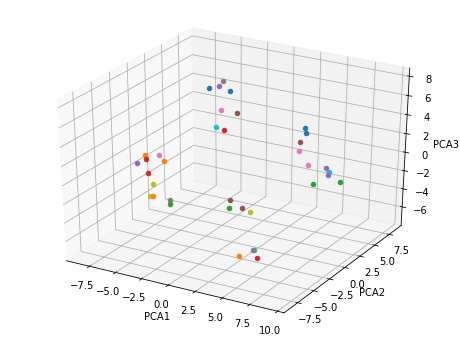

In [10]:
# graph the 3 primary components in a 3d dimension graph

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(df_project)):
    ax.scatter(df_project.iloc[:,0][i], df_project.iloc[:,1][i], df_project.iloc[:,2][i])
    
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

In [69]:
small_df.iloc[:,24].values

array([6, 4, 0, 2, 3, 7, 2, 6, 0, 1, 7, 0, 3, 1, 4, 2, 7, 1, 0, 3, 6, 1,
       5, 4, 3, 5, 4, 0, 5, 2, 7, 4, 3, 4, 6, 5, 3])

#### We can see that PCA does not work very well on clearly separating the clusters. I will also project the first two PCAs to produce Moriarty's graph.

Text(0, 0.5, 'PC2')

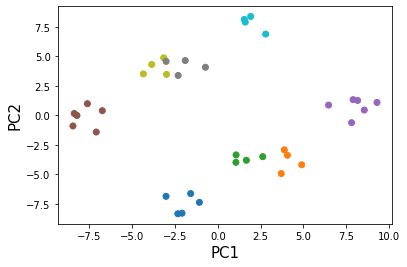

In [11]:
plt.scatter(df_project.iloc[:,0],df_project.iloc[:,1], c = small_df.iloc[:,24], 
            cmap='tab10')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)

#### I will repeat the procedure for the large data set.

In [12]:
large_centered = np.log(large_df.iloc[:,:32]+1).apply(lambda x: x-x.mean(0))
large_centered.head()

,currant,watercress,cantaloupe,cauliflower,onion,ginger,horseradish,endive,lavender,guava,...,chickpea,pumpkin,lime,elderberry,plantain,tangerine,avocado,watermelon,mushroom,lettuce
0,0.060939,-2.494990,0.311710,-1.794531,2.132608,-2.393053,-2.333998,-2.460251,0.138949,-2.168551,...,0.964975,-3.131199,-3.109372,-0.614169,0.454928,-2.188980,3.591623,0.880419,0.510070,0.524803
1,-0.222423,-1.801843,-0.178913,-1.101384,-1.944929,2.423188,0.263386,-2.460251,0.198138,2.643633,...,-0.791869,1.937705,2.439705,0.217565,-0.283475,1.836371,-2.656420,-2.674929,-0.596841,0.421262
2,0.714346,1.060358,-0.941053,1.175883,2.479918,-2.393053,-0.408707,2.651737,-0.156897,2.021104,...,-1.099353,-2.438052,-2.416224,0.619100,-0.360436,1.712992,2.299407,3.888927,0.268156,0.102808
3,-1.338428,-1.396378,-0.195720,-1.389066,-0.692166,2.256134,-2.333998,-1.361639,0.914013,-2.168551,...,-1.373790,2.298146,0.933680,1.423888,-2.326549,-2.882128,-1.046982,-2.674929,0.358670,-1.881323
4,0.426664,-2.494990,1.491933,-2.487678,3.123975,1.558191,0.284440,-2.460251,1.363441,-2.168551,...,-0.257786,2.916173,2.218505,0.578934,-0.465797,-2.188980,2.248855,2.287916,1.002546,0.626056


In [13]:
U2, S2, WT2 = np.linalg.svd(large_centered, full_matrices=False)
U2.shape, S2.shape, WT2.shape

((1679, 32), (32,), (32, 32))

In [14]:
S2

array([203.49323328, 196.21760138, 174.91505936, 155.05021092,
        40.42264574,  39.77727167,  38.72342393,  38.34050409,
        38.0149355 ,  37.89011957,  37.28127723,  36.83953464,
        36.64720042,  36.02418774,  35.92508497,  35.52577545,
        35.50156224,  35.07224421,  34.40234749,  33.83249086,
        32.07639087,  31.41993781,  30.87415889,  30.54550237,
        30.40907117,  30.054291  ,  29.90005867,  29.73260756,
        29.2513995 ,  28.90144281,  28.60322415,  27.91189804])

#### By the eigenvalues here it seems that the first four components are most significant. I will plot the first three and then the first two to re-produce Moriarty's graph.

In [15]:
W2 = WT2.T
lcomponents = large_centered @ W2
df_lproject = lcomponents.iloc[:,:4].rename(columns ={0:'PC1', 1:'PC2', 2:'PC3', 3:'PC4'})
df_lproject.head()

,PC1,PC2,PC3,PC4
0,-2.293502,2.137891,-5.723787,7.032071
1,0.580302,3.279254,8.015354,-1.378507
2,3.647069,2.201950,-7.900069,-3.502664
3,-3.901965,-2.763788,4.995741,3.247140
4,-8.899226,1.842828,-0.346373,1.845930


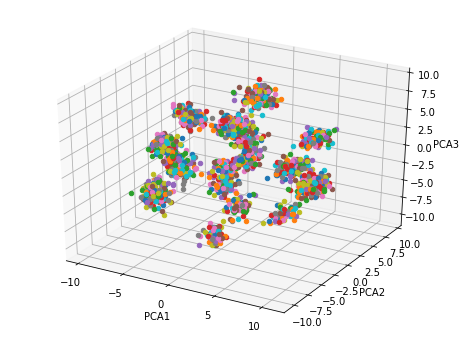

In [16]:
# graph the 3 primary components in a 3d dimension graph

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(df_lproject)):
    ax.scatter(df_lproject.iloc[:,0][i], df_lproject.iloc[:,1][i], df_lproject.iloc[:,2][i])
    
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

#### Produce Moriarty's graph for the large data.

Text(0, 0.5, 'PC2')

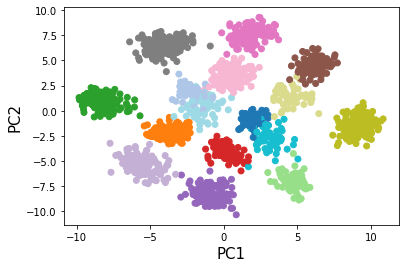

In [17]:
plt.scatter(df_lproject.iloc[:,0], df_lproject.iloc[:,1], 
            c = large_df.iloc[:,32], cmap='tab20')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)

#### Not sure how to graph in 4D but from the 2D and 3D graphs PCA is not clearly separating the clusters.

#### 2. implement t-SNE for yourself
Implement your own version of t-SNE, following the description in the lecture notes and the van der Maaten and Hinton (2008) paper. Look especially to "Algorithm 1" in van der Maaten and Hinton (2008) for an outline.

Your version should implement:

the objective function (the Kullback-Leibler distance between the high-dimensional P and the 2-dimensional Q, equation 2 in the van der Maaten paper), and its gradient (eqn 5);

for that, you will also need to implement the calculation of P (pg. 2584) and Q (eqn 4);

for P, first you need pj∣i (eqn 1), and for pj∣i, you need to calculate σi values for each point i given a target perplexity value. You'll probably find that the σi optimization is the most annoying step; see lecture notes and the hints below for help on doing this one-dimensional optimization of each σi.

You don't need to implement the t-SNE optimization for the pset (though you can if you want! I'd be impressed.) Instead, use SciPy's scipy.optimize.minimize(), as we used in regression in week07. Write your objective function and gradient routine to be compatible with the SciPy optimizer.

t-SNE's objective function isn't convex; it has lots of local optima, and it's easy for it to get locked up in crappy spurious ones. Real t-SNE implementations are decked out with bells and whistles in their optimization. "Early compression" and "early exaggeration" allow points to slide past each other in early iterations to find a better global clustering. As the number of data points increases, these tricks become more and more necessary. If you try the larger Moriarty data set, you'll probably find, as I did, that the SciPy optimizer doesn't suffice for it. It will suffice on the smaller Moriarty data set though.

Use your t-SNE implementation to visualize Moriarty's smaller data set in two t-SNE dimensions; show your t-SNE figure.

In [76]:
# convert small data to logs

small_log = np.log(small_df.iloc[:,:24]+1)
small_log.shape

(37, 24)

In [75]:
# Calculates a distance matrix which contains pairwise Euclidian distances between all points i, j.

def calc_D(X):
    D=np.zeros([len(X),len(X)])
    for i in range(len(X)):
        for j in range(len(X)):
            D[i,j]=np.linalg.norm(X[i]-X[j]) 
    return D

Perplexity function (with scipy's bisection optimizer): finding the sigmas that match the desired perplexity. It calculates the perplexity of an input sigma value and returns the difference between calculated perplexity and desired perplexity. <br>
The Shannon entropy formula is used here: $ H_i = - \sum_j p_{j \mid i} \log_2 p_{j \mid i} $ 

In [51]:
def perplexity_diff(sigmai, Di, perplexity):
    pji_cond = np.exp((-Di**2)/(2*sigmai**2))
    sum_pji =np.sum(pji_cond)
    pji_cond /=sum_pji
    H = 0 
    for i in range(len(Di)):
        if pji_cond[i]>0: 
            H -= pji_cond[i]*np.log2(pji_cond[i]) 
    est_perplexity = 2**H
    difference = est_perplexity - perplexity
    return difference

Probabilities of visiting neighbors (joint p i j) over the conditional probabilty of j given i. Math formula:  $p_{ij}= \frac {p_{j \mid i}+ p_{i \mid j}} {2n}$

In [52]:
def calc_joint_pij(conditional_P, X):
    joint_pij = (conditional_P+conditional_P.T)/(2*len(X))
    return joint_pij

Probability of j given i is as function of its distance in proportion to a spherical Gaussian distribution. Math formula: $ p_{j \mid i} = \frac { \exp \left( - \lVert x_i - x_j \rVert^2 , / , 2\sigma_i^2 \right) } { \sum_{k \neq i} \exp \left( - \lVert x_i - x_k \rVert^2 , / , 2\sigma_i^2 \right) } $

In [53]:
def calc_cond_pji(X, sigma, D):
    pji_cond = np.zeros([len(X), len(X)])
    for i in range(len(X)):
        for j in range(len(X)):
            if i != j:
                denom = np.sum(np.exp(-1*(D[:, i]**2)/(2*sigma[i]**2))) - np.exp(-1*(D[i, i]**2)/(2*sigma[i]**2))
                pji_cond[j,i] = np.exp(-1*(D[j, i]**2)/(2*sigma[i]**2))/denom
            else: # if i = j, then p(j|i) is set to zero
                pji_cond[j,i] = 0
    return pji_cond

Calculate qj∣i probabilities. Math formula: $ q_{ij} = \frac { \left( 1 + \lVert y_i - y_j \rVert^2 \right)^{-1} } { \sum_{k \neq l} \left( 1 + \lVert y_k - y_l \rVert^2 \right)^{-1} } $


In [54]:
def calc_Qij(Y):
    Qij=np.zeros([len(Y),len(Y)])
    sum_q=0
    for i in range(len(Y)):
        for j in range(len(Y)):  
            if i!=j: 
                Qij[i,j]=1/(1+np.linalg.norm(Y[i]-Y[j])**2)
                sum_q+=Qij[i,j]
    Qij/=sum_q
    return Qij

Kullback-Leibler divergence to minimize the difference between two probability distributions. Math formula: $ \mathrm{KL} = \sum_i \sum_j p_{ij} \log \frac{p_{ij}} {q_{ij}} $
Math formula that is used to minimize the KL distance (gradient): $ \frac {\partial f} {\partial y_i} = 4 \sum_j (p_{ij} - q_{ij}) (y_i - y_j) (1 + \lVert y_i - y_j \rVert^2)^{-1} $

In [55]:
def KL_dist(Y, Pij):
    M  = Pij.shape[0]   
    Y  = np.reshape(Y, (M,2))
    Qij  = calc_Qij(Y)
    KL = 0
    gradient = np.zeros([M,2])
    for i in range(M):
        for j in range(M):
            gradient[i]+=((Pij[i,j]-Qij[i,j])*(Y[i]-Y[j]))/(1+np.linalg.norm(Y[i]-Y[j])**2)
            if Pij[i,j]>0:
                KL +=Pij[i,j]*np.log(Pij[i,j]/Qij[i,j])
        gradient[i]*=4
    return KL, gradient.flatten()

##### Wrapping everything in my tSNE function.

In [77]:
def tSNE(X, perp_input,iterations):
    
    D = calc_D(X) # calculate distance matrix
    KL_best=np.inf
    sigma = np.zeros(len(X))
    for i in range(len(X)): # find intervals where sign changes
        a = 1.0
        b = 1.0
        while perplexity_diff(a, D[i], perp_input) >= 0:
            a /= 2
        while perplexity_diff(b, D[i], perp_input) <= 0:
            b *= 2
        sigma[i] = scipy.optimize.bisect(perplexity_diff, a, b, args=(D[i].flatten(), perp_input))
        
    p_ji_cond = calc_cond_pji(X, sigma, D) # calculate conditional p|ji
    p_ij_joint = calc_joint_pij(p_ji_cond, X) # calculate joint pij 
    
    for i in range(iterations):
        Y = np.random.normal(0., 1e-4, (len(X),2))  # choosing from a small 2D Gaussian centered at zero. 
        result = scipy.optimize.minimize(KL_dist, Y.flatten(), args=(p_ij_joint), jac=True)
        Y = result.x.reshape(len(X), 2)
        if result.fun<KL_best:
            KL_best=result.fun
            Y_best=Y
    return Y_best, KL_best

In [60]:
# iterate tSNE 10 times
Y, KL = tSNE(small_log.values,5,10)

In [61]:
print('Best KL divergence: ',KL)

Best KL divergence:  0.0639535355608714


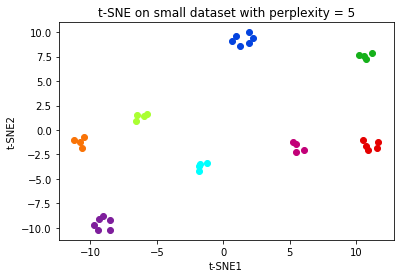

In [106]:
# Plot results
Color = [ 'xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue',
          'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
          'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
          'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy' ]

fig, ax = plt.subplots(1,1)
for i in range(len(small_log.values)):
    ax.plot(Y[i,0], Y[i,1], 'o', mfc=Color[small_df.iloc[:,24].values[i]], markersize=6, mec=Color[small_df.iloc[:,24].values[i]])
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE on small dataset with perplexity = 5")
plt.show()

#### It works, but it takes time to run, although I used the small data set.

#### 3. using the canned t-SNE from scikit
scikit-learn provides a suite of machine learning tools in Python, including sklearn.manifold.TSNE. You probably already have it installed with your Anaconda installation. See if "from sklearn.manifold import TSNE" works for you. If not, install scikit-learn with conda:

    %  conda install scikit-learn
Use sklearn.manifold.TSNE to visualize both the small and large Moriarty data sets in two t-SNE dimensions, for four different choices of perplexity: 2, 5, 30, and 100. Show your plots.

In [79]:
small_log = np.log(small_df.iloc[:,:24]+1)
small_log.head()

,nectarine,cauliflower,pineapple,tangerine,watermelon,papaya,endive,ginger,lettuce,broccoli,...,onion,lime,guava,parsley,chickpea,horseradish,wasabi,artichoke,pumpkin,zucchini
0,4.521789,3.871201,3.891820,5.609472,4.442651,4.709530,6.075346,0.000000,4.234107,3.761200,...,4.682131,1.098612,5.758902,5.273000,4.584967,2.397895,4.394449,0.000000,0.000000,3.761200
1,5.463832,0.693147,5.736572,3.610918,4.595120,4.262680,1.098612,0.693147,5.480639,4.248495,...,4.867534,1.386294,5.877736,4.356709,4.736198,5.411646,4.844187,0.693147,1.098612,4.691348
2,0.000000,0.693147,3.784190,0.000000,4.653960,3.637586,1.098612,1.791759,5.049856,4.369448,...,6.054439,0.693147,0.000000,3.713572,2.995732,5.446737,3.912023,1.098612,0.000000,4.882802
3,1.098612,4.369448,2.995732,0.693147,5.446737,4.369448,2.772589,1.098612,4.753590,4.584967,...,4.663439,0.000000,0.000000,5.117994,3.761200,3.555348,4.127134,0.000000,1.386294,2.484907
4,1.098612,5.814131,5.463832,0.000000,3.091042,4.382027,5.017280,4.442651,4.653960,4.488636,...,3.912023,6.274762,0.000000,4.700480,5.030438,4.442651,5.501258,4.644391,5.463832,3.091042


In [80]:
large_log = np.log(large_df.iloc[:,:32]+1)
large_log.head()

,currant,watercress,cantaloupe,cauliflower,onion,ginger,horseradish,endive,lavender,guava,...,chickpea,pumpkin,lime,elderberry,plantain,tangerine,avocado,watermelon,mushroom,lettuce
0,4.343805,0.000000,4.584967,0.693147,4.770685,0.693147,1.945910,0.000000,4.406719,0.693147,...,5.283204,0.000000,0.000000,3.610918,4.727388,0.693147,6.248043,3.555348,4.795791,4.804021
1,4.060443,0.693147,4.094345,1.386294,0.693147,5.509388,4.543295,0.000000,4.465908,5.505332,...,3.526361,5.068904,5.549076,4.442651,3.988984,4.718499,0.000000,0.000000,3.688879,4.700480
2,4.997212,3.555348,3.332205,3.663562,5.117994,0.693147,3.871201,5.111988,4.110874,4.882802,...,3.218876,0.693147,0.693147,4.844187,3.912023,4.595120,4.955827,6.563856,4.553877,4.382027
3,2.944439,1.098612,4.077537,1.098612,1.945910,5.342334,1.945910,1.098612,5.181784,0.693147,...,2.944439,5.429346,4.043051,5.648974,1.945910,0.000000,1.609438,0.000000,4.644391,2.397895
4,4.709530,0.000000,5.765191,0.000000,5.762051,4.644391,4.564348,0.000000,5.631212,0.693147,...,4.060443,6.047372,5.327876,4.804021,3.806662,0.693147,4.905275,4.962845,5.288267,4.905275


In [110]:
perplexity_range = [2,5,30,100]
slabels = []
llabels = []
for p in perplexity_range:
    slabels.append(TSNE(perplexity=p).fit_transform(small_log))
    llabels.append(TSNE(perplexity=p).fit_transform(large_log))

Text(0, 0.5, 't-SNE2')

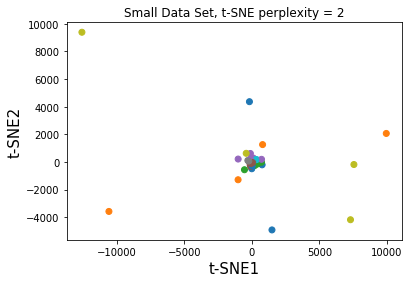

In [111]:
plt.scatter(slabels[0][:,0],
            slabels[0][:,1], 
            c = small_df.iloc[:,24], cmap='tab10')
plt.title('Small Data Set, t-SNE perplexity = 2')
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)

Text(0, 0.5, 't-SNE2')

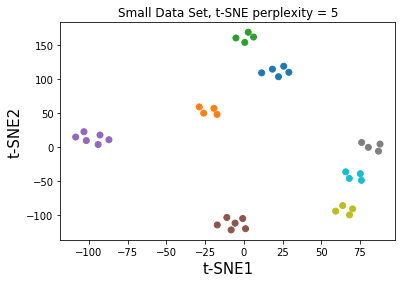

In [112]:
plt.scatter(slabels[1][:,0],
            slabels[1][:,1], 
            c = small_df.iloc[:,24], cmap='tab10')
plt.title('Small Data Set, t-SNE perplexity = 5')
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)

Text(0, 0.5, 't-SNE2')

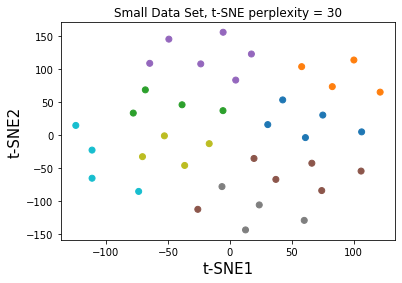

In [84]:
plt.scatter(slabels[2][:,0],
            slabels[2][:,1],
            c = small_df.iloc[:,24], cmap='tab10')
plt.title('Small Data Set, t-SNE perplexity = 30')
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)

Text(0, 0.5, 't-SNE2')

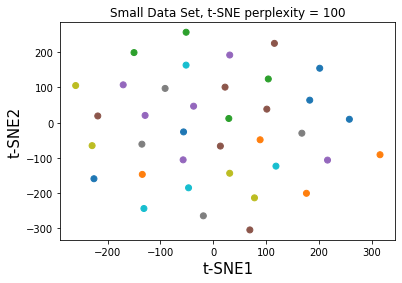

In [85]:
plt.scatter(slabels[3][:,0],
            slabels[3][:,1], 
            c = small_df.iloc[:,24], cmap='tab10')
plt.title('Small Data Set, t-SNE perplexity = 100')
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)

#### For the small data set, perplexities 30 and 100 do not work well, most likely because of the small number of data. It appears that the perplexity value should be lower than the number of data. The best perplexity is 5, which matches the cluster size of the data set.

Text(0, 0.5, 't-SNE2')

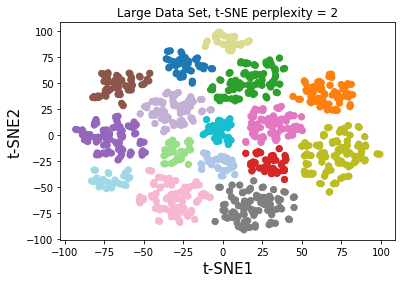

In [86]:
plt.scatter(llabels[0][:,0],
            llabels[0][:,1], 
            c = large_df.iloc[:,32], cmap='tab20')
plt.title('Large Data Set, t-SNE perplexity = 2')
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)

Text(0, 0.5, 't-SNE2')

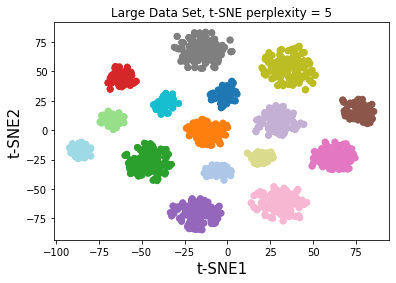

In [87]:
plt.scatter(llabels[1][:,0],
            llabels[1][:,1],
            c = large_df.iloc[:,32], cmap='tab20')
plt.title('Large Data Set, t-SNE perplexity = 5')
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)

Text(0, 0.5, 't-SNE2')

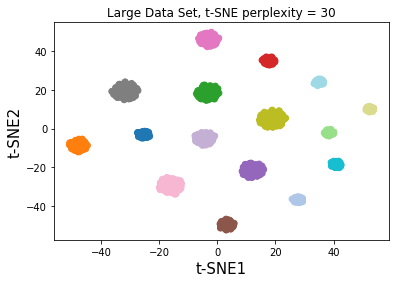

In [88]:
plt.scatter(llabels[2][:,0],
            llabels[2][:,1],
            c = large_df.iloc[:,32], cmap='tab20')
plt.title('Large Data Set, t-SNE perplexity = 30')
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)

Text(0, 0.5, 't-SNE2')

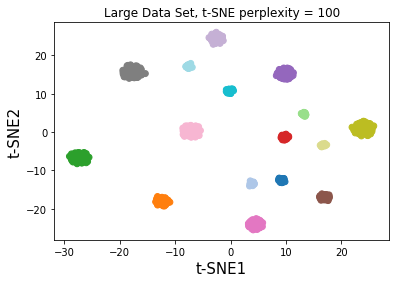

In [89]:
plt.scatter(llabels[3][:,0],
            llabels[3][:,1], 
            c = large_df.iloc[:,32], cmap='tab20')
plt.title('Large Data Set, t-SNE perplexity = 100')
plt.xlabel('t-SNE1', fontsize=15)
plt.ylabel('t-SNE2', fontsize=15)

#### For the large set all perplexities work well. The conclusion is that tSNE worked, while PCA did not.